In [1]:
# imports & parquet dateien einlesen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_info = pd.read_parquet("../filtered_data/match_info.parquet")
df_general = pd.read_parquet("../filtered_data/match_player_general.parquet")
df_ts = pd.read_parquet("../filtered_data/match_player_timestamp.parquet")


In [2]:
#finale abilitypoints Stand pro Spieler
last_ts = df_ts.sort_values("timestamp_s").groupby(["match_id", "account_id"]).tail(1)

player_team = df_general[["match_id", "account_id", "team"]].drop_duplicates()
last_ts_team = last_ts.merge(player_team, on=["match_id", "account_id"], how="left")

team_ap = (
    last_ts_team.groupby(["match_id", "team"])["ability_points"]
    .mean()
    .reset_index()
)

team_ap_wide = team_ap.pivot(
    index="match_id",
    columns="team",
    values="ability_points"
).reset_index()

# abilitypoints-Diff (Team0 - Team1)
team_ap_wide["ap_diff"] = team_ap_wide["Team0"] - team_ap_wide["Team1"]

merged_ap = team_ap_wide.merge(df_info[["match_id", "winning_team"]], on="match_id")

# winning team a-points advantage
merged_ap["ap_advantage_winner"] = (
    merged_ap["ap_diff"].apply(lambda x: "Team0" if x > 0 else "Team1")
    == merged_ap["winning_team"]
)

print(merged_ap.head())
print("Ability-Advantage Accuracy:", merged_ap["ap_advantage_winner"].mean())


   match_id      Team0      Team1   ap_diff winning_team  ap_advantage_winner
0  43904454  15.333333  18.833333 -3.500000        Team1                 True
1  43904692  23.833333  24.166667 -0.333333        Team1                 True
2  43904884  25.333333  22.166667  3.166667        Team0                 True
3  43904997  15.500000  18.666667 -3.166667        Team1                 True
4  43905132  19.333333  22.500000 -3.166667        Team1                 True
Ability-Advantage Accuracy: 0.8478620823999221


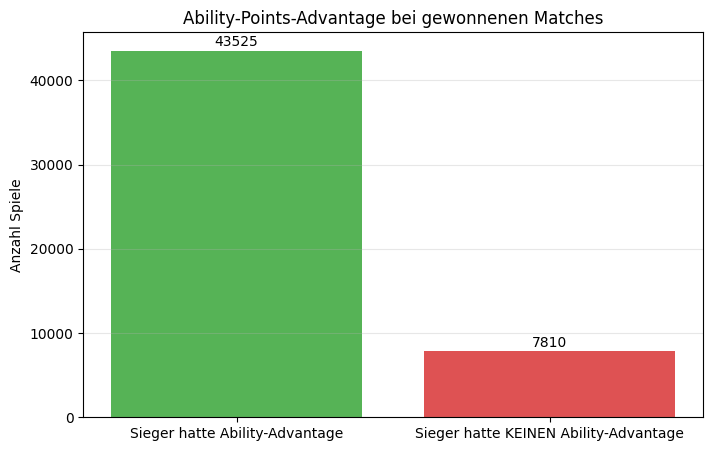

In [3]:
# Plot: Wie oft gewinnt der Ability-Leader? (Advantage vs Comeback)
total_wins = len(merged_ap)
ap_advantage_wins = merged_ap["ap_advantage_winner"].sum()
ap_comeback_wins = total_wins - ap_advantage_wins

labels = ["Sieger hatte Ability-Advantage", "Sieger hatte KEINEN Ability-Advantage"]
values = [ap_advantage_wins, ap_comeback_wins]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=["tab:green", "tab:red"], alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + total_wins * 0.01,
             f"{height}", ha='center', fontsize=10)

plt.title("Ability-Points-Advantage bei gewonnenen Matches")
plt.ylabel("Anzahl Spiele")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [ ]:
player_team = df_general[["match_id", "account_id", "team"]].drop_duplicates()

df_ts_team = df_ts.merge(
    player_team,
    on=["match_id", "account_id"],
    how="left"
)

team_ap_ts = (
    df_ts_team
    .groupby(["match_id", "timestamp_s", "team"])["ability_points"]
    .mean()
    .reset_index()
)

team_ap_ts_wide = team_ap_ts.pivot(
    index=["match_id", "timestamp_s"],
    columns="team",
    values="ability_points"
).reset_index()

#a-points diff
team_ap_ts_wide["ap_diff"] = team_ap_ts_wide["Team0"] - team_ap_ts_wide["Team1"]

#winning team
ap_ts = team_ap_ts_wide.merge(
    df_info[["match_id", "winning_team"]],
    on="match_id",
    how="left"
)

#a-points lead/ timestamp
ap_ts["leading_team"] = ap_ts["ap_diff"].apply(
    lambda x: "Team0" if x > 0 else "Team1"
)

ap_ts["lead_correct"] = ap_ts["leading_team"] == ap_ts["winning_team"]

total_matches = ap_ts["match_id"].nunique()

ap_summary_by_time = (
    ap_ts.groupby("timestamp_s")
    .agg(
        avg_ap_diff=("ap_diff", "mean"),
        avg_abs_ap_diff=("ap_diff", lambda s: s.abs().mean()),
        lead_accuracy=("lead_correct", "mean"),
        matchcount=("match_id", "nunique")
    )
    .reset_index()
)

ap_summary_by_time["match_pct"] = ap_summary_by_time["matchcount"] / total_matches * 100

print(ap_summary_by_time.head())
print(ap_summary_by_time.to_string(index=False))


   timestamp_s  avg_ap_diff  avg_abs_ap_diff  lead_accuracy  matchcount  \
0          180    -0.002396         0.068368       0.524145       51335   
1          360    -0.031622         0.400903       0.598520       51335   
2          540    -0.039782         0.628878       0.629255       51321   
3          720    -0.043406         0.809645       0.656980       51306   
4          900    -0.038260         0.808193       0.680463       51246   

    match_pct  
0  100.000000  
1  100.000000  
2   99.972728  
3   99.943508  
4   99.826629  
 timestamp_s  avg_ap_diff  avg_abs_ap_diff  lead_accuracy  matchcount  match_pct
         180    -0.002396         0.068368       0.524145       51335 100.000000
         360    -0.031622         0.400903       0.598520       51335 100.000000
         540    -0.039782         0.628878       0.629255       51321  99.972728
         720    -0.043406         0.809645       0.656980       51306  99.943508
         900    -0.038260         0.808193      

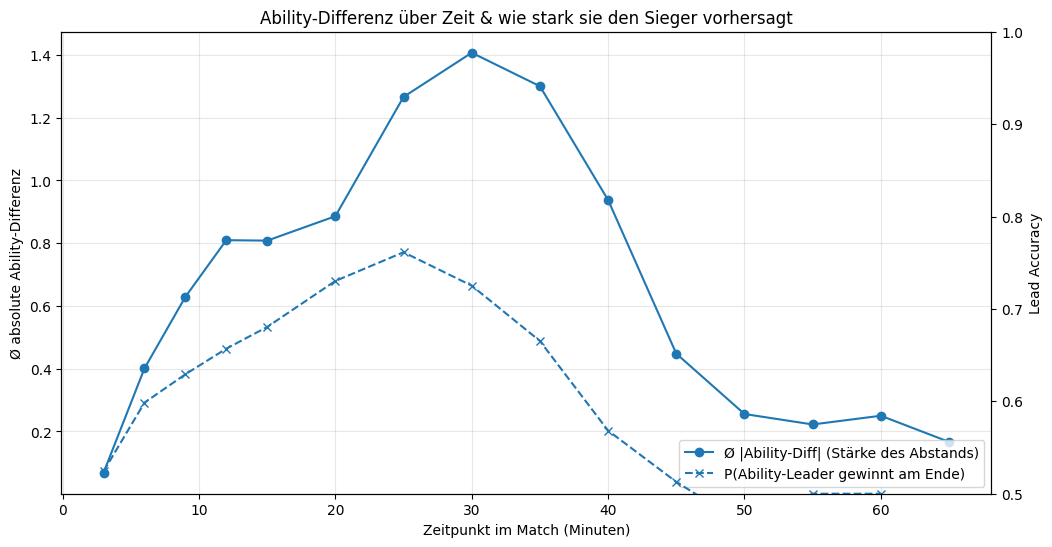

In [ ]:
# Plot: Ability-Differenz über Zeit & Vorhersagekraft in einem Plot
ap_summary_by_time["timestamp_min"] = ap_summary_by_time["timestamp_s"] / 60

plt.figure(figsize=(12, 6))
ax1 = plt.gca()

#durchschnittliche absolute Ability-Differenz
ax1.plot(
    ap_summary_by_time["timestamp_min"],
    ap_summary_by_time["avg_abs_ap_diff"],
    marker="o",
    label="Ø |Ability-Diff| (Stärke des Abstands)"
)
ax1.set_xlabel("Zeitpunkt im Match (Minuten)")
ax1.set_ylabel("Ø absolute Ability-Differenz")
ax1.grid(True, alpha=0.3)

#Lead Accuracy
ax2 = ax1.twinx()
ax2.plot(
    ap_summary_by_time["timestamp_min"],
    ap_summary_by_time["lead_accuracy"],
    marker="x",
    linestyle="--",
    label="P(Ability-Leader gewinnt am Ende)"
)
ax2.set_ylabel("Lead Accuracy")
ax2.set_ylim(0.5, 1.0)

plt.title("Ability-Differenz über Zeit & wie stark sie den Sieger vorhersagt")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.show()


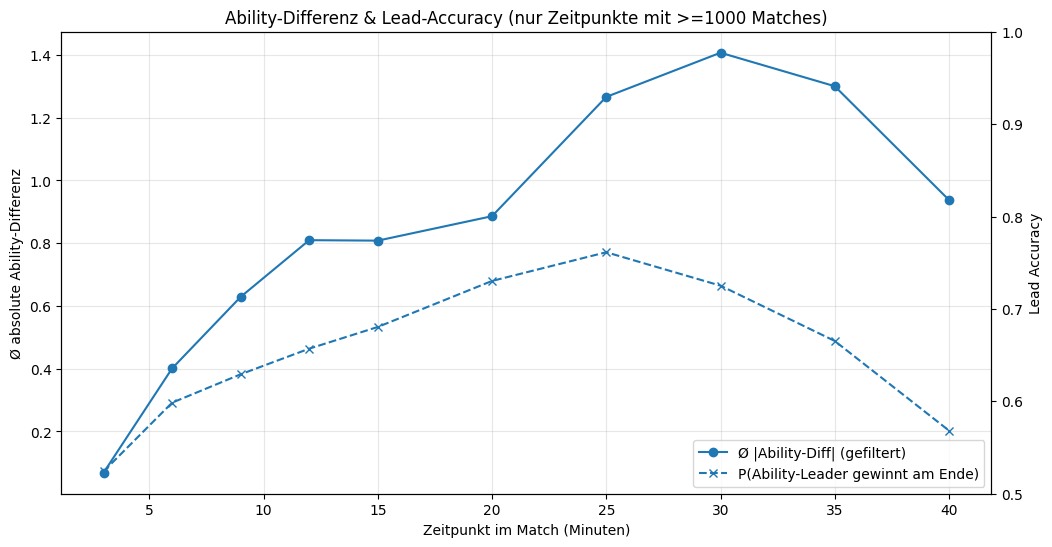

In [ ]:
#nur Zeitpunkte mit >= 1000 Matches
filtered_ap = ap_summary_by_time[ap_summary_by_time["matchcount"] >= 1000].copy()
filtered_ap["timestamp_min"] = filtered_ap["timestamp_s"] / 60

plt.figure(figsize=(12, 6))
ax1 = plt.gca()

ax1.plot(
    filtered_ap["timestamp_min"],
    filtered_ap["avg_abs_ap_diff"],
    marker="o",
    label="Ø |Ability-Diff| (gefiltert)"
)
ax1.set_xlabel("Zeitpunkt im Match (Minuten)")
ax1.set_ylabel("Ø absolute Ability-Differenz")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(
    filtered_ap["timestamp_min"],
    filtered_ap["lead_accuracy"],
    marker="x",
    linestyle="--",
    label="P(Ability-Leader gewinnt am Ende)"
)
ax2.set_ylabel("Lead Accuracy")
ax2.set_ylim(0.5, 1.0)

plt.title("Ability-Differenz & Lead-Accuracy (nur Zeitpunkte mit >=1000 Matches)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.show()
